# Ensemble Classification

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support, ConfusionMatrixDisplay, classification_report, make_scorer, fbeta_score, RocCurveDisplay, DetCurveDisplay

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [3]:
data_full = pd.read_csv("../data/processed/full_all_day_ahead.csv")
cols_1da = [c for c in data_full.columns if c.endswith("_1") or c == "Abnormal"]
data_1da = data_full[cols_1da]
data_1da = data_1da.dropna()
data_1da_reduced = data_1da.drop(columns="RR_1")
X = data_1da_reduced.drop(columns="Abnormal")
y = data_1da_reduced.Abnormal

np.random.seed(500)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y)
class_bal = pd.concat([pd.Series(y_test).value_counts(), pd.Series(y_train).value_counts()], axis=1)

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
X_train_reduced = X_train.drop(columns=["DPB_1", "DPH_1", "HTH_1", "TAGI_1", "RRIR_1", "TLRR_1", "OGO_1"])

In [11]:
model_configs = {
  "rf": {
    "clf": RandomForestClassifier(n_jobs=-1),
    "param_grid": {
      "clf__n_estimators": [50, 100, 250],
      "clf__min_samples_split": [2, 3, 4],
      "clf__max_depth": [None, 2, 5, 10]
    }
  },
  "xgb": {
    "clf": XGBClassifier(n_jobs=-1, eval_metric=make_scorer(fbeta_score, beta=2)),
    "param_grid": {
      "clf__max_depth": [x for x in range(11)],
      "clf__max_delta_step": [x for x in range(5)],
      "clf__learning_rate": [0.01, 0.1, 0.2, 0.3],
      "clf__n_estimators": [50, 75, 100]
    }
  },
}

def perform_grid_search_fit(model_config, X_fit, y_fit):
  clf = model_config["clf"]
  param_grid = model_config["param_grid"]
  pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", clf)
  ])
  kf = StratifiedKFold(n_splits=10)
  search = RandomizedSearchCV(pipe, param_grid, cv=kf, n_iter=60, scoring=make_scorer(fbeta_score, beta=2), n_jobs=-1, refit=True)
  search.fit(X_fit, y_fit)

  return (search.best_estimator_, search.best_params_)

best_models = {}
for name, model_config in model_configs.items():
  best_model, best_params = perform_grid_search_fit(model_config, X_train, y_train)
  best_models[name] = {
    "model": best_model,
    "params": best_params
  }

c:\Users\willc\OneDrive\OMSA\03 SP24 ISYE7406 DMSL\Project\dmsl-project\env\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 36 is smaller than n_iter=60. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params for model rf: {'clf__n_estimators': 250, 'clf__min_samples_split': 3, 'clf__max_depth': None}
Best params for model xgb: {'clf__n_estimators': 100, 'clf__max_depth': 5, 'clf__max_delta_step': 2, 'clf__learning_rate': 0.3}


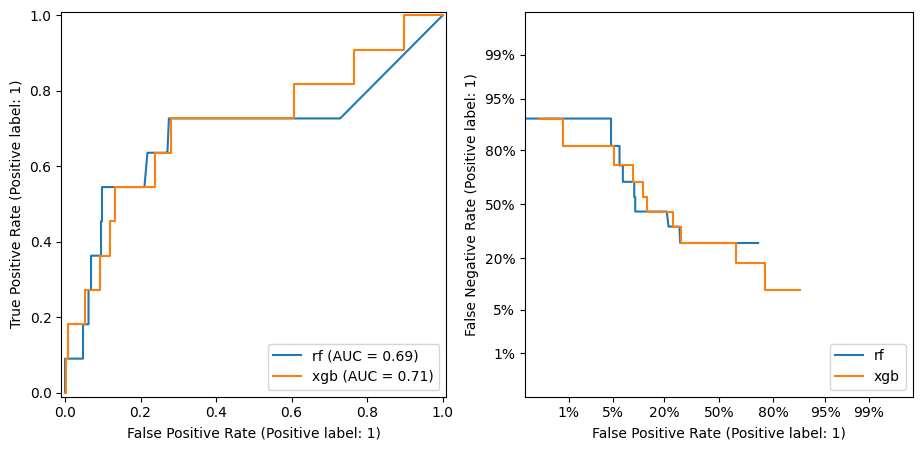

In [12]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, best_model in best_models.items():
  mod = best_model["model"]
  params = best_model["params"]
  print(f"Best params for model {name}: {params}")
  RocCurveDisplay.from_estimator(mod, X_test, y_test, ax=ax_roc, name=name)
  DetCurveDisplay.from_estimator(mod, X_test, y_test, ax=ax_det, name=name)